In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from narrative import nar181026_heat_confidence_genes
# from narrative import nar181101_single_cell
from narrative import nar181205_networks

In [6]:
save_images = True

In [7]:
outfolder = '221011_transcript_length_tilting'

In [8]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [9]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

In [10]:
tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung', 'Musc', 'AM', 'AT2', 'MoDC'] 



In [11]:
all_de['tissue'].value_counts()

Lung          1469385
AT2           1330239
MoDC          1291319
AM            1159674
Blood         1151200
Cerebellum     522224
Skin           514485
Stomach        514295
Adrenal        513116
LI             502097
SI             501136
Kidney         500097
Esophagus      497821
WAT            490950
GutEP          481126
Brain          475768
MuscSat        466050
BAT            463731
Liver          463594
Heart          400125
Name: tissue, dtype: int64

In [12]:
all_de = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['gene_ncbi'].isin(ref_genes))

]


In [13]:
from scipy.stats import spearmanr

In [14]:
from natsort import natsorted

In [15]:
conditions = natsorted(all_de['condition'].unique())

In [16]:
out = pd.DataFrame(index=conditions, columns=[
    'corr', 'pval'
]).rename_axis('condition')

In [17]:
pr = properties.genbank_validated_rna(10090)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [18]:
%%time

for condition in conditions:
    d = all_de[
        (all_de['de_unit']=='both') & (all_de['condition']==condition)
    ]

    d = d[['gene_ncbi', 'o_over_y', 'log_padj', 'log_pvalue']].dropna()
    d = pd.merge(d, pr)

    r, p = spearmanr(d['log_length'], d['o_over_y'])
    d = d.set_index('gene_ncbi')

    out.loc[condition, 'corr'] = r
    out.loc[condition, 'pval'] = p
    out.loc[condition, 'genes'] = d.shape[0]

CPU times: user 5min 47s, sys: 59.2 s, total: 6min 46s
Wall time: 2min 46s


In [19]:
# out = out.dropna()

In [20]:
out = out.reset_index()

In [21]:
out = pd.merge(out, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [22]:
mega = pd.merge(
    out,
    all_de[['condition', 'tissue', 'younger', 'older']].drop_duplicates()
)

In [23]:

if save_images:
    export.export_full_frame('{}/stats_on_imbalance.xlsx'.format(outfolder), mega, save_index=False)

In [24]:
out.head()

,condition,corr,pval,genes,younger,older
0,AM_0_4_9,-0.239285,1.89389e-18,1305.0,4.0,9.0
1,AM_0_4_12,0.0382141,0.000637698,7983.0,4.0,12.0
2,AM_0_4_18,-0.0636075,6.27412e-08,7224.0,4.0,18.0
3,AM_0_4_24,-0.099084,2.43693e-18,7736.0,4.0,24.0
4,AM_0_9_12,0.0852567,1.42384e-16,9361.0,9.0,12.0


In [25]:
u = out[out['younger']==4]

In [26]:
u['corr'] = u['corr'].astype(float)

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
u['older'] = u['older'].astype(float)

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
u = pd.merge(
    u,
    all_de[['condition', 'tissue']].drop_duplicates())

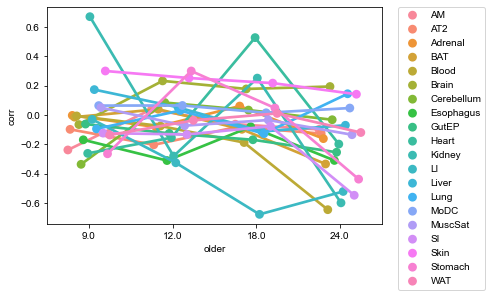

In [29]:
sns.pointplot(x='older', y='corr', hue='tissue', data=u, dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
if save_images:
    export.export_image('{}/tissue_line_4months_to_older.pdf'.format(outfolder))

In [30]:
u[u['older']==24].sort_values('corr')

,condition,corr,pval,genes,younger,older,tissue
19,Blood_0_4_24,-0.646453,3.79871e-95,794.0,4.0,24.0,Blood
43,Kidney_0_4_24,-0.599801,0,8197.0,4.0,24.0,Kidney
67,SI_0_4_24,-0.548157,0,6036.0,4.0,24.0,SI
47,LI_0_4_24,-0.522198,0,9807.0,4.0,24.0,LI
75,Stomach_0_4_24,-0.438255,2.5601e-268,5745.0,4.0,24.0,Stomach
15,BAT_0_4_24,-0.334887,1.30268e-218,8376.0,4.0,24.0,BAT
31,Esophagus_0_4_24,-0.310671,1.92384e-151,6772.0,4.0,24.0,Esophagus
35,GutEP_0_4_24,-0.254853,6.09979e-122,8214.0,4.0,24.0,GutEP
39,Heart_0_4_24,-0.199111,4.54656e-101,11263.0,4.0,24.0,Heart
11,Adrenal_0_4_24,-0.162002,1.07144e-58,9814.0,4.0,24.0,Adrenal


In [31]:
from scipy.stats import mannwhitneyu

In [32]:
mannwhitneyu(
    u[u['older']==18]['corr'],
    u[u['older']==24]['corr'],
)

MannwhitneyuResult(statistic=111.0, pvalue=0.008334399412137733)

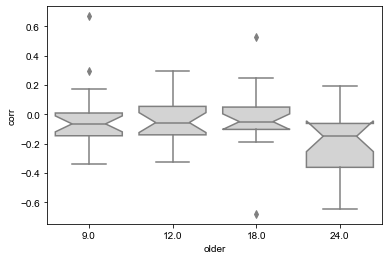

In [33]:
sns.boxplot(x='older', y='corr', data=u, notch=True, color='lightgrey')

if save_images:
    export.export_image('{}/box_4months_to_older.pdf'.format(outfolder))

In [34]:
u = out.copy()

In [35]:
u['older'] = u['older'].astype(float)
u['corr'] = u['corr'].astype(float)

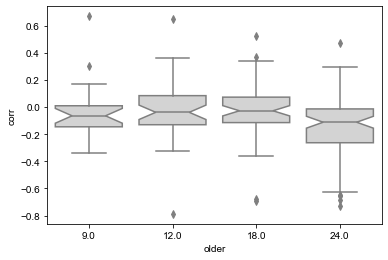

In [36]:
sns.boxplot(x='older', y='corr', data=u, notch=True, color='lightgrey')
if save_images:
    export.export_image('{}/box_any_age_to_older.pdf'.format(outfolder))

In [37]:
u[(u['younger']==4) & (u['older']==18)].sort_values('corr')

,condition,corr,pval,genes,younger,older
112,LI_0_4_18,-0.678338,0,8603.0,4.0,18.0
42,Blood_0_4_18,-0.188596,1.49011e-74,9217.0,4.0,18.0
82,GutEP_0_4_18,-0.169653,8.05382e-68,10371.0,4.0,18.0
132,Lung_0_4_18,-0.127924,1.85842e-39,10472.0,4.0,18.0
122,Liver_0_4_18,-0.113116,2.01273e-31,10562.0,4.0,18.0
32,BAT_0_4_18,-0.098445,6.38218e-19,8109.0,4.0,18.0
12,AT2_0_4_18,-0.081396,4.30455e-16,9945.0,4.0,18.0
72,Esophagus_0_4_18,-0.081018,1.61055e-12,7581.0,4.0,18.0
162,SI_0_4_18,-0.077829,1.47054e-15,10482.0,4.0,18.0
2,AM_0_4_18,-0.063608,6.27412e-08,7224.0,4.0,18.0


In [38]:
u[(u['younger']==4) & (u['older']==24)].sort_values('corr')

,condition,corr,pval,genes,younger,older
43,Blood_0_4_24,-0.646453,3.79871e-95,794.0,4.0,24.0
103,Kidney_0_4_24,-0.599801,0,8197.0,4.0,24.0
163,SI_0_4_24,-0.548157,0,6036.0,4.0,24.0
113,LI_0_4_24,-0.522198,0,9807.0,4.0,24.0
183,Stomach_0_4_24,-0.438255,2.5601e-268,5745.0,4.0,24.0
33,BAT_0_4_24,-0.334887,1.30268e-218,8376.0,4.0,24.0
73,Esophagus_0_4_24,-0.310671,1.92384e-151,6772.0,4.0,24.0
83,GutEP_0_4_24,-0.254853,6.09979e-122,8214.0,4.0,24.0
93,Heart_0_4_24,-0.199111,4.54656e-101,11263.0,4.0,24.0
23,Adrenal_0_4_24,-0.162002,1.07144e-58,9814.0,4.0,24.0


In [39]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==18)]['corr'],
    u[(u['younger']==4) & (u['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=289.0, pvalue=0.016668798824275466)

In [40]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==9)]['corr'],
    u[(u['younger']==4) & (u['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=273.0, pvalue=0.04986369021054049)

In [41]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==12)]['corr'],
    u[(u['younger']==4) & (u['older']==24)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=276.0, pvalue=0.04112359406047486)

In [42]:
mannwhitneyu(
    u[(u['younger']==4) & (u['older']==9)]['corr'],
    u[(u['younger']==4) & (u['older']==18)]['corr'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=173.0, pvalue=0.4734806277722057)